# Hand gesture recognition model validation present

> Edited from: Gesture Recognizer with MediaPipe Tasks

## Preparation

Let's start with installing MediaPipe.

In [1]:
# !pip install mediapipe==0.10.0

Then download an off-the-shelf model. This model can recognize 15 hand gestures. 

## Visualization Utilities

In [2]:
#@markdown We implemented some functions to visualize the gesture recognition results. <br/> Run the following cell to activate the functions.
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
import math

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images_with_gestures_and_hand_landmarks(images, results):
    """Displays a batch of images with the gesture category and its score along with the hand landmarks."""
    # Images and labels.
    images = [image.numpy_view() for image in images]
    gestures = [top_gesture for (top_gesture, _) in results]
    multi_hand_landmarks_list = [multi_hand_landmarks for (_, multi_hand_landmarks) in results]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display gestures and hand landmarks.
    for i, (image, gestures) in enumerate(zip(images[:rows*cols], gestures[:rows*cols])):
        title = f"{gestures.category_name} ({gestures.score:.2f})"
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        annotated_image = image.copy()

        for hand_landmarks in multi_hand_landmarks_list[i]:
          hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
          hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
          ])

          mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        subplot = display_one_image(annotated_image, title, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

## Download test images

Let's grab some test images.

In [3]:
import os
import random
import json
import shutil
from PIL import Image

# source_dir = "E:/MyDatasets/hagrid_dataset_512"
source_dir = "F:/files/hagrid_dataset_512/hagrid_dataset_512"
# target_dir = "C:/Users/Ian/git/553.806_Capstone_HandGesture/datasets/dataset_valid"
target_dir = "D:/Projects/553.806_Capstone_HandGesture/datasets/dataset_valid"
# annotations_dir = "C:/Users/Ian/git/553.806_Capstone_HandGesture/annotations/val"
annotations_dir = "D:/Projects/553.806_Capstone_HandGesture/annotations/val"
labels = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted']     # 12 gestures: 🤙, 👎, ✊, 👍, 🤐, 👌, ☝, 🖐, ✌, 🤘, ✋, 🤚
NUM_EXAMPLES = 5
IMAGE_FILENAMES = []

if os.path.exists(target_dir):
    # Remove the directory and all its contents
    shutil.rmtree(target_dir)

os.makedirs(target_dir, exist_ok=True)

# Function to read JSON annotations
def read_annotations(label):
    annotation_path = os.path.join(annotations_dir, f"{label}.json")
    with open(annotation_path, 'r') as file:
        annotations = json.load(file)
    return annotations

# Function to crop image based on the bounding box
def crop_image(image_path, bbox):
    with Image.open(image_path) as img:
        width, height = img.size
        x0 = int(bbox[0] * width)
        y0 = int(bbox[1] * height)
        x1 = x0 + int(bbox[2] * width)
        y1 = y0 + int(bbox[3] * height)
        return img.crop((x0, y0, x1, y1))

# Iterate over labels (annotation files)
for label in labels:
    label_name = label.split('.')[0]  # Remove file extension to get the label
    annotations = read_annotations(label_name)

    selected_images = []
    keys = list(annotations.keys())
    selected_keys = random.sample(keys, min(NUM_EXAMPLES, len(keys)))
    for key in selected_keys:
        image_name_with_ext = f"{key}.jpg"
        image_path = os.path.join(source_dir, label_name, image_name_with_ext)
        if os.path.exists(image_path):
            label_idx = annotations[key]['labels'].index(label_name)
            selected_images.append((image_name_with_ext, annotations[key]['bboxes'][label_idx]))

    # Copy and crop selected images
    target_subdir = os.path.join(target_dir, label_name)
    os.makedirs(target_subdir, exist_ok=True)
    for image_name, bbox in selected_images:
        source_image_path = os.path.join(source_dir, label_name, image_name)
        cropped_image = crop_image(source_image_path, bbox)
        target_image_path = os.path.join(target_subdir, image_name)
        IMAGE_FILENAMES.append(target_image_path)
        cropped_image.save(target_image_path)
print(IMAGE_FILENAMES)

['D:/Projects/553.806_Capstone_HandGesture/datasets/dataset_valid\\call\\6acae964-39fa-474b-a6b8-c8af5615657c.jpg', 'D:/Projects/553.806_Capstone_HandGesture/datasets/dataset_valid\\call\\1b44c6f6-ee23-4c83-8d87-254941d08a96.jpg', 'D:/Projects/553.806_Capstone_HandGesture/datasets/dataset_valid\\call\\b1cb3f6f-168d-4b7d-95a8-d76fd690497f.jpg', 'D:/Projects/553.806_Capstone_HandGesture/datasets/dataset_valid\\call\\0b34d8f5-c92c-4bea-8fea-e7ba884ebad9.jpg', 'D:/Projects/553.806_Capstone_HandGesture/datasets/dataset_valid\\call\\bdb08588-f293-40b5-b9b6-19a7f4de4cd0.jpg', 'D:/Projects/553.806_Capstone_HandGesture/datasets/dataset_valid\\dislike\\6ba8df4f-b263-4beb-a823-8e42729dfa93.jpg', 'D:/Projects/553.806_Capstone_HandGesture/datasets/dataset_valid\\dislike\\7f78b87f-06e7-4729-a5ca-9b102c4aa202.jpg', 'D:/Projects/553.806_Capstone_HandGesture/datasets/dataset_valid\\dislike\\592c5137-66fe-4f6b-879d-2a9a481812c5.jpg', 'D:/Projects/553.806_Capstone_HandGesture/datasets/dataset_valid\\disl

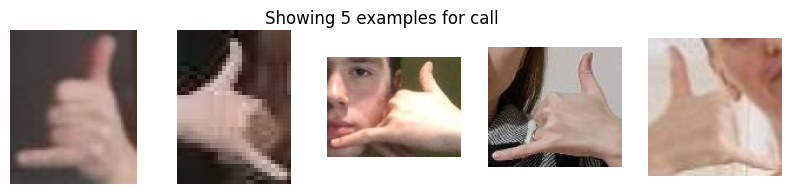

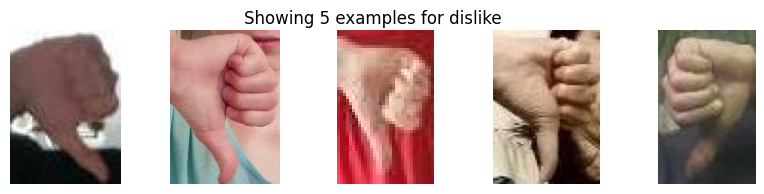

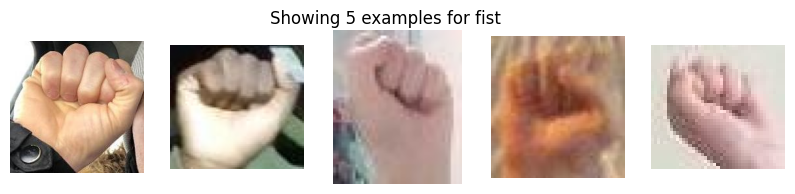

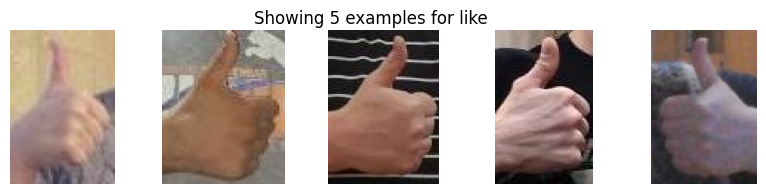

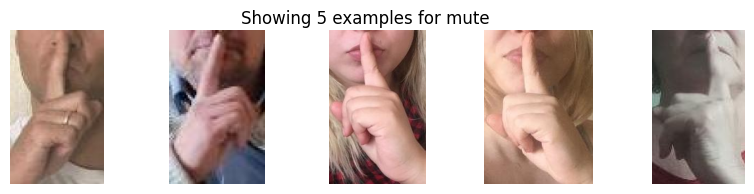

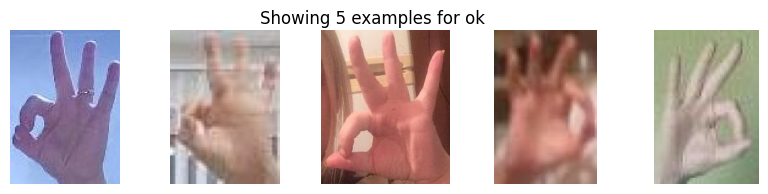

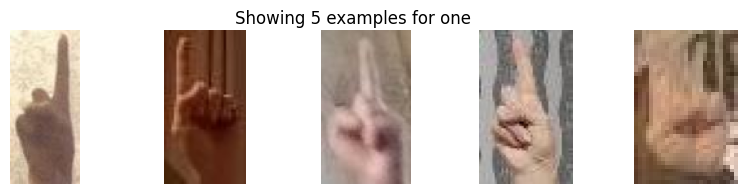

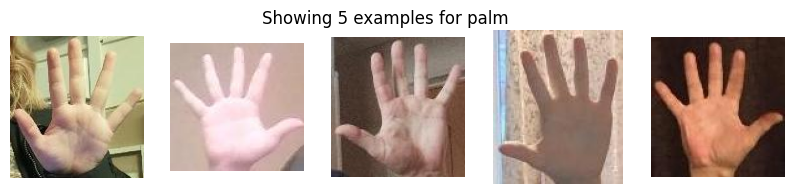

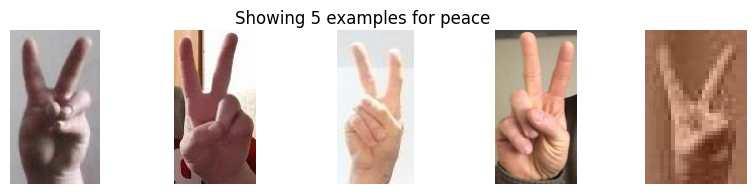

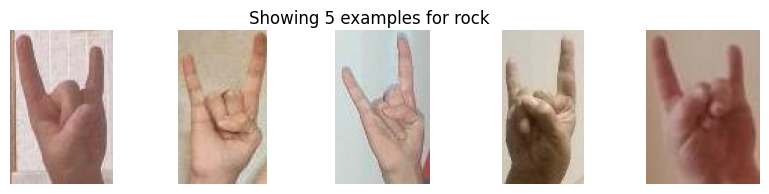

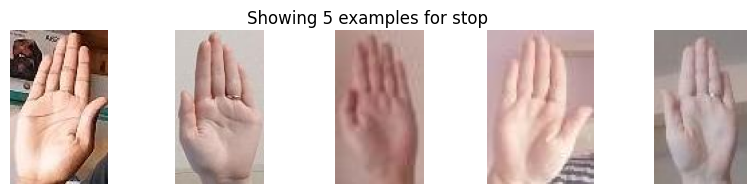

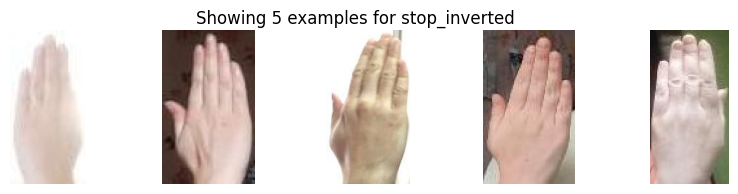

In [4]:

for label in labels:
    label_dir = os.path.join(target_dir, label)
    example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
    fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
    for i in range(NUM_EXAMPLES):
        axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

## Running inference and visualizing the results

Here are the steps to run gesture recognizer using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer/python) to learn more about configuration options that this solution supports.

*Note: Gesture Recognizer also returns the hand landmark it detects from the image, together with other useful information such as whether the hand(s) detected are left hand or right hand.*

In [5]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an GestureRecognizer object.
base_options = python.BaseOptions(model_asset_path='gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)

images = []
results = []
for image_file_name in IMAGE_FILENAMES:
  # STEP 3: Load the input image.
  image = mp.Image.create_from_file(image_file_name)

  # STEP 4: Recognize gestures in the input image.
  recognition_result = recognizer.recognize(image)
  if recognition_result.gestures == []:
    continue

  # STEP 5: Process the result. In this case, visualize it.
  images.append(image)
  top_gesture = recognition_result.gestures[0][0]
  hand_landmarks = recognition_result.hand_landmarks
  results.append((top_gesture, hand_landmarks))

display_batch_of_images_with_gestures_and_hand_landmarks(images, results)

RuntimeError: File loading is not yet supported on Windows